In [1]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import deepxde.deepxde as dde
from datasets import makeTesting_dr
from datasets import parallel_solver, diffusion_reaction_solver
from utils.func import dirichlet, periodic, L2norm, L2_TO_DATA
from utils.PDETriple import PDETripleCartesianProd

date = time.strftime("%Y%m%d-%H-%M-%S", time.localtime())
# dde.config.set_random_seed(2023)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
total_training_vx = 300
ls = 0.05

check_num = 1000
select_num = 20
solver_worker = 0

lr_start = 5e-3
lr_middle = 5e-3
lr_end = 5e-3

iter_start = 20000
iter_middle = 40000
iter_end = 60000

batch_start = lambda n: 2
batch_middle = lambda n: n // 5
batch_end = lambda n: n

decay_start = None
decay_middle = None
decay_end = None

if False:
    makeTesting_dr(length_scale = ls)

In [3]:
def pde(x, y, aux):
    D = 0.01
    k = 0.01
    dy_t = dde.grad.jacobian(y, x[1], j=1)
    dy_xx = dde.grad.hessian(y, x[1], j=0)
    out = dy_t - D * dy_xx + k * y**2 - aux
    return out

class boundary():
    def __init__(self, loss_coeff = 1, value = 0):
        self.loss_coeff = loss_coeff
        self.value = value
    
    def __call__(self, targets, outputs):
        return self.loss_coeff * (outputs - self.value).abs().mean()

In [4]:
space = dde.data.GRF(1.0, length_scale = ls, N= 1000, interp="cubic")

geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
vxs = space.eval_batch(space.random(select_num), np.linspace(0, 1, 101)[:, None])
uxts = parallel_solver(diffusion_reaction_solver, vxs, num_workers = solver_worker)
grid = uxts[0][0].reshape(101 * 101, -1)
uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)


train_vxs = vxs
train_grid = grid
train_uxts = uxts
print(train_vxs.shape, train_grid.shape, train_uxts.shape)

test_data = np.load(f"datasets/DF_100_{ls:.2f}_101_101.npz")
test_vxs = test_data["vxs"]
test_grid = test_data["xt"].reshape(-1, 2)
test_uxts = test_data["uxts"].reshape(-1, 101 * 101)
del test_data
print(test_vxs.shape, test_grid.shape, test_uxts.shape)

(20, 101) (10201, 2) (20, 10201)
(100, 101) (10201, 2) (100, 10201)


In [5]:
init_indices = (grid[:, 1] == 0).nonzero()[0]
bound_indices = np.logical_or(grid[:, 0] == 0, grid[:, 0] == 1).nonzero()[0]
boundary_losses = []
boundary_losses.append((init_indices, boundary()))
boundary_losses.append((bound_indices, boundary()))
print(init_indices.shape, bound_indices.shape)

(101,) (202,)


In [6]:
data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])

# Net
net = dde.nn.DeepONetCartesianProd(
    [101, 100, 100],
    [2, 100, 100, 100],
    "gelu",
    "Glorot normal",
)

# net.apply_feature_transform(periodic)
net.apply_output_transform(dirichlet)

model = dde.Model(data, net)
model.compile("adam", 
              lr= lr_start, 
              loss= ["mse"], 
              metrics = ["mean l2 relative error"], 
              decay = decay_start)


Compiling model...
'compile' took 0.003850 s



Training model...

Step      Train loss    Test loss     Test metric   
0         [2.76e-01]    [1.77e-01]    [1.02e+00]    
1000      [3.74e-02]    [4.97e-02]    [5.66e-01]    
2000      [6.40e-02]    [1.34e+00]    [2.16e+00]    
3000      [3.62e-02]    [1.00e+00]    [1.89e+00]    
4000      [3.08e-02]    [8.34e-01]    [1.73e+00]    
5000      [1.55e-02]    [6.73e-01]    [1.61e+00]    
6000      [1.19e-02]    [4.95e-01]    [1.43e+00]    
7000      [1.11e-02]    [3.91e-01]    [1.27e+00]    
8000      [1.16e-02]    [3.01e-01]    [1.16e+00]    
9000      [2.15e-03]    [1.77e-01]    [9.51e-01]    
10000     [5.80e-03]    [2.11e-01]    [9.89e-01]    
11000     [4.59e-03]    [2.72e-01]    [1.09e+00]    
12000     [4.40e-03]    [1.65e-01]    [9.20e-01]    
13000     [3.62e-03]    [2.10e-01]    [1.00e+00]    
14000     [4.27e-03]    [5.16e-02]    [5.67e-01]    
15000     [4.01e-03]    [4.92e-02]    [5.50e-01]    
16000     [1.68e-03]    [4.60e-02]    [5.26e-01]    
17000     [9.73e-04]    [4.

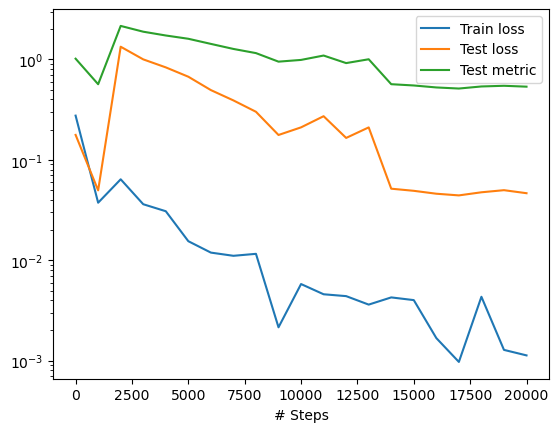

In [7]:
losshistory, train_state = model.train(iterations = iter_start, batch_size = batch_start(len(train_vxs)))
dde.utils.plot_loss_history(losshistory)

In [8]:
losshistory.to_pandas().to_csv(f"results/loss_history_{date}_l22d.csv", index=False)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,5))

v = test_vxs[1]
x = np.linspace(0,1,v.shape[0])

ax1.set_xlim(0,1)
ax1.scatter(x, v, s=1)

ut = test_uxts[0]
xt = test_grid

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
ax2.set_aspect('equal')
ax2.scatter(xt[...,0], xt[...,1], c=ut)

out = model.predict((test_vxs[(0,),...], xt))

ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
ax3.set_aspect('equal')
ax3.scatter(xt[...,0], xt[...,1], c=out)

plt.tight_layout()
plt.show()

14.633336880757593 1.422991512711329
40
Compiling model...
'compile' took 0.000426 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.88e-02]    [4.66e-02]    [5.36e-01]    
1000      [8.05e-04]    [1.95e-02]    [3.51e-01]    
2000      [4.95e-04]    [1.83e-02]    [3.38e-01]    
3000      [5.06e-04]    [1.70e-02]    [3.27e-01]    
4000      [5.55e-04]    [1.62e-02]    [3.20e-01]    
5000      [9.12e-04]    [1.57e-02]    [3.16e-01]    
6000      [1.92e-04]    [1.51e-02]    [3.10e-01]    
7000      [1.35e-04]    [1.43e-02]    [3.02e-01]    
8000      [7.97e-04]    [1.49e-02]    [3.08e-01]    
9000      [2.72e-04]    [1.44e-02]    [3.00e-01]    
10000     [6.29e-04]    [1.53e-02]    [3.05e-01]    
11000     [4.51e-04]    [1.47e-02]    [3.05e-01]    
12000     [7.26e-05]    [1.41e-02]    [2.97e-01]    
13000     [2.27e-03]    [1.68e-02]    [3.19e-01]    
14000     [2.32e-04]    [1.43e-02]    [3.02e-01]    
15000     [4.77e-04]    [1.42e-02]    [2.98e-01

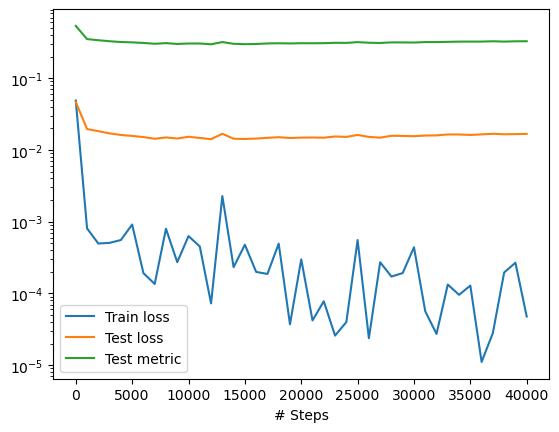

16.297814027118292 1.2303403117900185
60
Compiling model...
'compile' took 0.000211 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [9.84e-03]    [1.67e-02]    [3.27e-01]    
1000      [5.31e-05]    [6.63e-03]    [2.25e-01]    
2000      [3.14e-04]    [6.41e-03]    [2.22e-01]    
3000      [8.21e-05]    [6.44e-03]    [2.22e-01]    
4000      [1.26e-04]    [6.15e-03]    [2.18e-01]    
5000      [2.97e-05]    [6.20e-03]    [2.18e-01]    
6000      [3.09e-05]    [6.10e-03]    [2.17e-01]    
7000      [1.52e-05]    [6.05e-03]    [2.16e-01]    
8000      [6.93e-05]    [6.13e-03]    [2.17e-01]    
9000      [1.21e-04]    [6.06e-03]    [2.16e-01]    
10000     [3.97e-04]    [5.95e-03]    [2.14e-01]    
11000     [1.93e-05]    [5.82e-03]    [2.13e-01]    
12000     [1.04e-04]    [5.78e-03]    [2.12e-01]    
13000     [4.26e-04]    [5.94e-03]    [2.16e-01]    
14000     [1.43e-04]    [5.72e-03]    [2.12e-01]    
15000     [6.80e-04]    [6.35e-03]    [2.20e-0

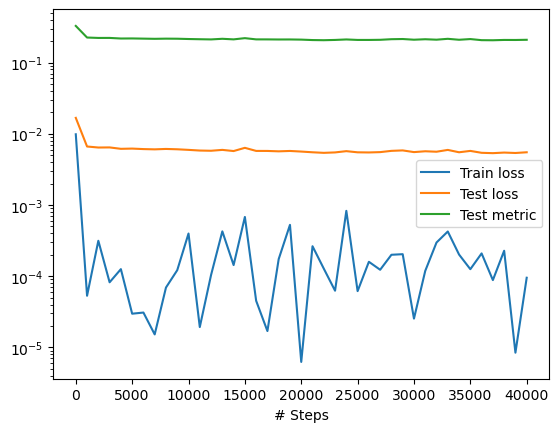

16.75716533573798 1.191324718332766
80
Compiling model...
'compile' took 0.000331 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.72e-03]    [5.50e-03]    [2.09e-01]    
1000      [4.89e-05]    [3.71e-03]    [1.78e-01]    
2000      [3.33e-05]    [3.68e-03]    [1.77e-01]    
3000      [1.44e-04]    [3.93e-03]    [1.82e-01]    
4000      [4.50e-05]    [3.64e-03]    [1.76e-01]    
5000      [1.50e-04]    [3.85e-03]    [1.80e-01]    
6000      [3.83e-04]    [3.70e-03]    [1.76e-01]    
7000      [6.85e-06]    [3.63e-03]    [1.75e-01]    
8000      [1.69e-05]    [3.61e-03]    [1.74e-01]    
9000      [9.98e-05]    [3.56e-03]    [1.73e-01]    
10000     [4.98e-05]    [3.58e-03]    [1.73e-01]    
11000     [4.33e-05]    [3.54e-03]    [1.73e-01]    
12000     [1.78e-04]    [3.91e-03]    [1.80e-01]    
13000     [9.45e-05]    [3.61e-03]    [1.75e-01]    
14000     [1.11e-05]    [3.54e-03]    [1.72e-01]    
15000     [1.11e-04]    [3.47e-03]    [1.69e-01]

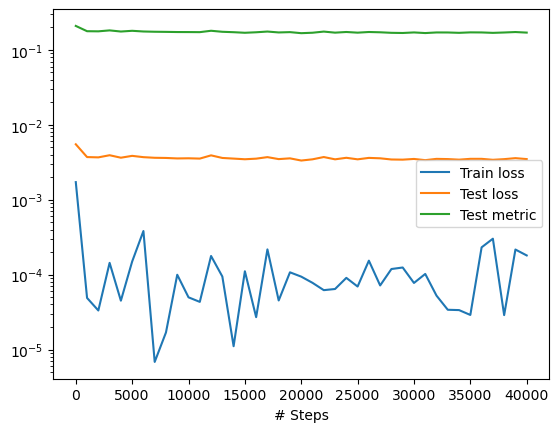

17.136910575130265 1.1715029091252829
100
Compiling model...
'compile' took 0.000321 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.45e-03]    [3.49e-03]    [1.70e-01]    
1000      [3.96e-05]    [2.57e-03]    [1.48e-01]    
2000      [3.57e-05]    [2.46e-03]    [1.45e-01]    
3000      [1.80e-04]    [2.51e-03]    [1.45e-01]    
4000      [3.96e-05]    [2.35e-03]    [1.41e-01]    
5000      [9.90e-05]    [2.41e-03]    [1.43e-01]    
6000      [1.11e-04]    [2.37e-03]    [1.41e-01]    
7000      [1.11e-04]    [2.33e-03]    [1.41e-01]    
8000      [5.97e-05]    [2.29e-03]    [1.39e-01]    
9000      [3.96e-05]    [2.24e-03]    [1.39e-01]    
10000     [2.45e-05]    [2.22e-03]    [1.38e-01]    
11000     [1.22e-04]    [2.25e-03]    [1.38e-01]    
12000     [2.94e-05]    [2.22e-03]    [1.38e-01]    
13000     [6.55e-05]    [2.18e-03]    [1.37e-01]    
14000     [1.22e-04]    [2.25e-03]    [1.38e-01]    
15000     [1.06e-04]    [2.12e-03]    [1.35e-

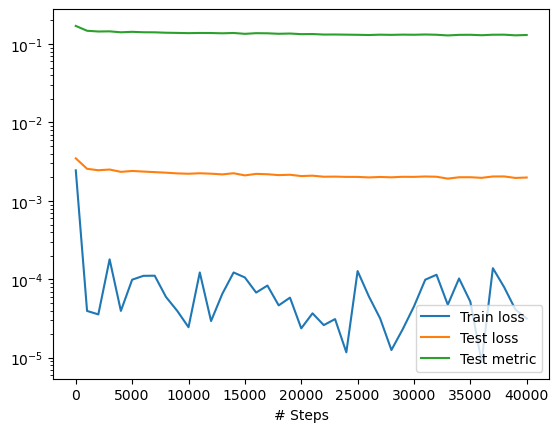

17.35697324640071 1.131833482050049
120
Compiling model...
'compile' took 0.000151 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.95e-04]    [1.99e-03]    [1.30e-01]    
1000      [1.12e-04]    [1.57e-03]    [1.15e-01]    
2000      [3.95e-05]    [1.53e-03]    [1.12e-01]    
3000      [4.54e-05]    [1.48e-03]    [1.11e-01]    
4000      [2.49e-05]    [1.46e-03]    [1.10e-01]    
5000      [2.36e-04]    [1.52e-03]    [1.11e-01]    
6000      [1.29e-04]    [1.45e-03]    [1.09e-01]    
7000      [1.64e-04]    [1.38e-03]    [1.07e-01]    
8000      [4.14e-05]    [1.38e-03]    [1.07e-01]    
9000      [2.11e-05]    [1.33e-03]    [1.05e-01]    
10000     [8.81e-05]    [1.36e-03]    [1.06e-01]    
11000     [8.19e-05]    [1.34e-03]    [1.06e-01]    
12000     [3.77e-05]    [1.32e-03]    [1.04e-01]    
13000     [5.20e-05]    [1.31e-03]    [1.04e-01]    
14000     [2.54e-04]    [1.29e-03]    [1.04e-01]    
15000     [1.41e-04]    [1.24e-03]    [1.01e-01

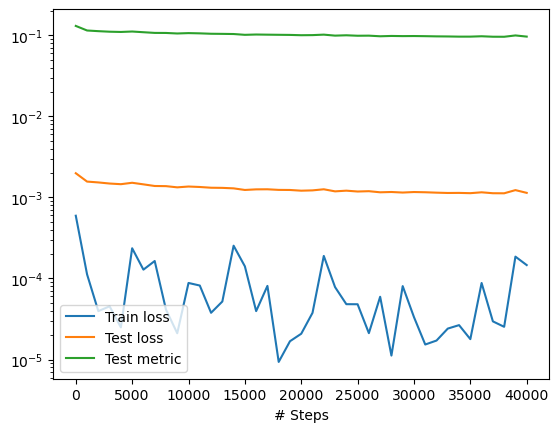

17.39317300967181 1.0997908456185095
140
Compiling model...
'compile' took 0.000258 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.76e-04]    [1.14e-03]    [9.63e-02]    
1000      [5.18e-05]    [8.71e-04]    [8.55e-02]    
2000      [7.55e-05]    [8.78e-04]    [8.50e-02]    
3000      [3.85e-05]    [8.44e-04]    [8.36e-02]    
4000      [2.35e-05]    [8.21e-04]    [8.24e-02]    
5000      [2.56e-05]    [8.27e-04]    [8.24e-02]    
6000      [4.58e-05]    [8.23e-04]    [8.24e-02]    
7000      [3.04e-05]    [7.88e-04]    [8.03e-02]    
8000      [2.03e-05]    [7.60e-04]    [7.91e-02]    
9000      [1.17e-05]    [7.54e-04]    [7.86e-02]    
10000     [7.36e-06]    [7.48e-04]    [7.82e-02]    
11000     [4.47e-05]    [7.81e-04]    [7.97e-02]    
12000     [6.60e-05]    [7.35e-04]    [7.77e-02]    
13000     [2.25e-05]    [7.21e-04]    [7.67e-02]    
14000     [6.20e-05]    [7.37e-04]    [7.73e-02]    
15000     [1.56e-05]    [7.10e-04]    [7.59e-0

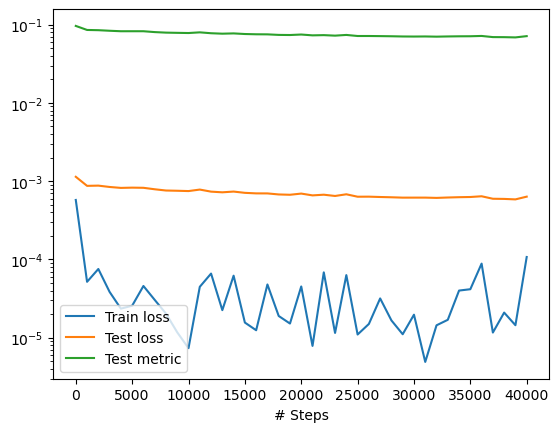

17.511507073038977 1.1165408546342375
160
Compiling model...
'compile' took 0.000155 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.84e-04]    [6.35e-04]    [7.13e-02]    
1000      [3.36e-05]    [5.47e-04]    [6.63e-02]    
2000      [1.40e-05]    [5.12e-04]    [6.42e-02]    
3000      [1.30e-05]    [5.10e-04]    [6.40e-02]    
4000      [4.68e-05]    [5.15e-04]    [6.42e-02]    
5000      [7.47e-06]    [4.97e-04]    [6.31e-02]    
6000      [1.16e-05]    [5.01e-04]    [6.32e-02]    
7000      [2.40e-05]    [4.86e-04]    [6.23e-02]    
8000      [1.40e-05]    [4.68e-04]    [6.13e-02]    
9000      [2.16e-05]    [4.63e-04]    [6.10e-02]    
10000     [4.15e-05]    [4.69e-04]    [6.14e-02]    
11000     [1.95e-05]    [4.67e-04]    [6.12e-02]    
12000     [3.27e-05]    [4.69e-04]    [6.14e-02]    
13000     [1.26e-05]    [4.45e-04]    [5.99e-02]    
14000     [1.10e-05]    [4.32e-04]    [5.90e-02]    
15000     [2.17e-05]    [4.31e-04]    [5.89e-

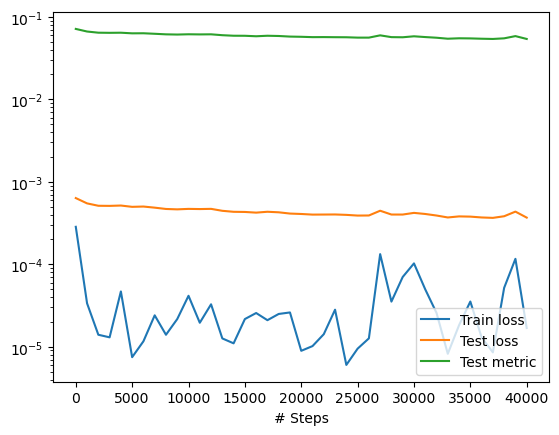

17.572800990490283 1.1275363972641381
180
Compiling model...
'compile' took 0.000149 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [8.52e-05]    [3.68e-04]    [5.39e-02]    
1000      [2.04e-05]    [2.70e-04]    [4.67e-02]    
2000      [2.21e-05]    [2.57e-04]    [4.57e-02]    
3000      [2.01e-05]    [2.40e-04]    [4.41e-02]    
4000      [8.58e-06]    [2.33e-04]    [4.34e-02]    
5000      [2.78e-05]    [2.35e-04]    [4.35e-02]    
6000      [5.79e-06]    [2.22e-04]    [4.23e-02]    
7000      [2.65e-05]    [2.26e-04]    [4.26e-02]    
8000      [3.94e-05]    [2.28e-04]    [4.28e-02]    
9000      [2.82e-05]    [2.11e-04]    [4.12e-02]    
10000     [7.81e-06]    [2.06e-04]    [4.06e-02]    
11000     [2.04e-05]    [2.02e-04]    [4.02e-02]    
12000     [7.64e-06]    [1.91e-04]    [3.91e-02]    
13000     [2.01e-05]    [1.93e-04]    [3.93e-02]    
14000     [6.05e-05]    [2.13e-04]    [4.12e-02]    
15000     [1.74e-05]    [1.83e-04]    [3.83e-

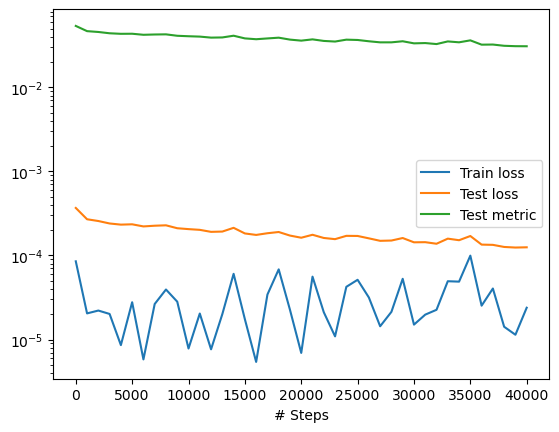

17.62073178180804 1.0802181993986304
200
Compiling model...
'compile' took 0.000158 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.29e-05]    [1.25e-04]    [3.09e-02]    
1000      [3.29e-05]    [1.05e-04]    [2.81e-02]    
2000      [5.66e-06]    [8.27e-05]    [2.48e-02]    
3000      [1.45e-05]    [8.14e-05]    [2.46e-02]    
4000      [1.99e-05]    [7.88e-05]    [2.42e-02]    
5000      [6.44e-06]    [7.00e-05]    [2.27e-02]    
6000      [5.16e-05]    [8.59e-05]    [2.51e-02]    
7000      [6.32e-05]    [8.35e-05]    [2.47e-02]    
8000      [6.95e-05]    [9.27e-05]    [2.62e-02]    
9000      [1.84e-05]    [6.46e-05]    [2.17e-02]    
10000     [3.12e-05]    [7.12e-05]    [2.29e-02]    
11000     [3.45e-06]    [5.44e-05]    [1.99e-02]    
12000     [1.09e-05]    [5.67e-05]    [2.04e-02]    
13000     [7.95e-06]    [5.30e-05]    [1.97e-02]    
14000     [5.84e-05]    [7.06e-05]    [2.30e-02]    
15000     [3.93e-06]    [4.90e-05]    [1.89e-0

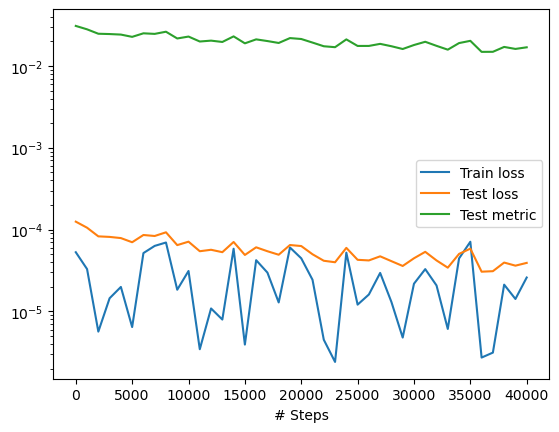

17.731522074275976 1.0652370412819518
220
Compiling model...
'compile' took 0.000147 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.83e-05]    [3.92e-05]    [1.69e-02]    
1000      [1.44e-05]    [3.16e-05]    [1.49e-02]    
2000      [1.38e-05]    [2.82e-05]    [1.40e-02]    
3000      [2.89e-05]    [3.83e-05]    [1.61e-02]    
4000      [6.56e-06]    [2.32e-05]    [1.27e-02]    
5000      [3.32e-05]    [3.23e-05]    [1.51e-02]    
6000      [7.45e-05]    [4.64e-05]    [1.78e-02]    
7000      [5.50e-05]    [4.26e-05]    [1.68e-02]    
8000      [2.12e-05]    [2.39e-05]    [1.30e-02]    
9000      [3.93e-06]    [1.62e-05]    [1.05e-02]    
10000     [1.20e-05]    [2.01e-05]    [1.20e-02]    
11000     [6.55e-06]    [1.63e-05]    [1.07e-02]    
12000     [2.54e-06]    [1.40e-05]    [9.78e-03]    
13000     [2.52e-06]    [1.33e-05]    [9.54e-03]    
14000     [1.56e-05]    [1.87e-05]    [1.14e-02]    
15000     [2.09e-05]    [1.99e-05]    [1.19e-

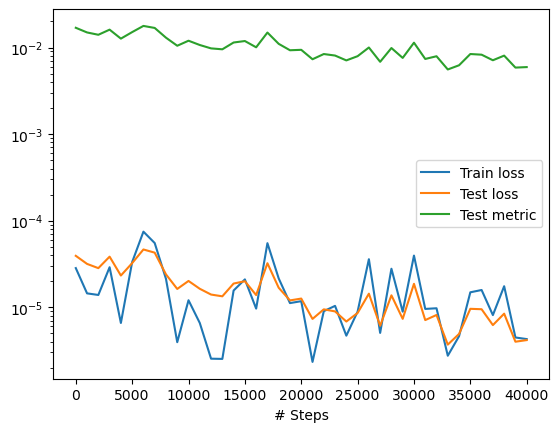

17.727329816419836 1.0811493347115406
240
Compiling model...
'compile' took 0.000149 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.12e-06]    [4.16e-06]    [5.94e-03]    
1000      [4.04e-06]    [4.20e-06]    [6.08e-03]    
2000      [2.81e-05]    [1.67e-05]    [1.13e-02]    
3000      [2.52e-05]    [1.43e-05]    [1.04e-02]    
4000      [7.65e-06]    [6.75e-06]    [7.46e-03]    
5000      [4.71e-06]    [4.10e-06]    [6.12e-03]    
6000      [8.15e-06]    [5.23e-06]    [6.82e-03]    
7000      [1.59e-05]    [9.04e-06]    [8.55e-03]    
8000      [6.87e-06]    [5.13e-06]    [6.67e-03]    
9000      [5.00e-06]    [4.20e-06]    [6.18e-03]    
10000     [9.87e-06]    [6.02e-06]    [7.16e-03]    
11000     [2.22e-05]    [1.19e-05]    [9.47e-03]    
12000     [7.26e-06]    [5.23e-06]    [6.72e-03]    
13000     [3.76e-06]    [3.71e-06]    [5.78e-03]    
14000     [1.02e-05]    [6.24e-06]    [7.18e-03]    
15000     [5.00e-06]    [4.45e-06]    [6.35e-

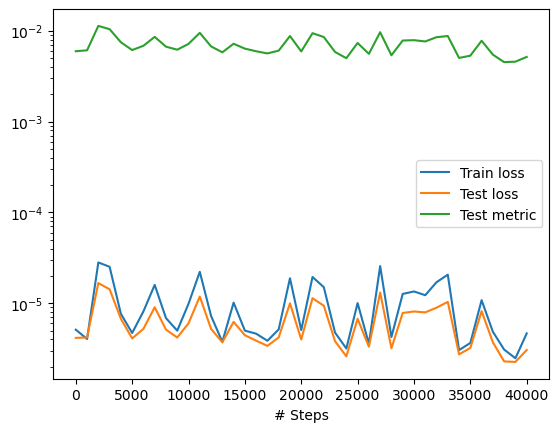

17.766138613833675 1.0815413916675356
260
Compiling model...
'compile' took 0.000144 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.58e-06]    [3.06e-06]    [5.14e-03]    
1000      [4.28e-06]    [3.36e-06]    [5.21e-03]    
2000      [1.48e-05]    [6.38e-06]    [6.97e-03]    
3000      [2.60e-06]    [2.15e-06]    [4.45e-03]    
4000      [7.25e-06]    [4.25e-06]    [5.84e-03]    
5000      [3.79e-06]    [3.00e-06]    [5.00e-03]    
6000      [2.56e-06]    [2.70e-06]    [4.91e-03]    
7000      [3.97e-06]    [2.59e-06]    [4.85e-03]    
8000      [3.33e-06]    [2.25e-06]    [4.49e-03]    
9000      [1.91e-05]    [1.14e-05]    [8.89e-03]    
10000     [2.50e-06]    [2.02e-06]    [4.23e-03]    
11000     [2.37e-05]    [1.23e-05]    [9.21e-03]    
12000     [2.48e-05]    [1.31e-05]    [9.37e-03]    
13000     [1.23e-05]    [7.13e-06]    [7.37e-03]    
14000     [1.37e-05]    [7.57e-06]    [7.18e-03]    
15000     [2.59e-06]    [2.41e-06]    [4.62e-

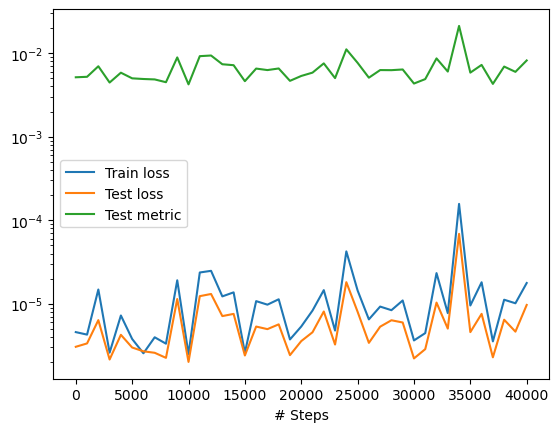

17.754673909348966 1.065310213771114
280
Compiling model...
'compile' took 0.000156 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.76e-05]    [9.69e-06]    [8.18e-03]    
1000      [7.33e-05]    [2.60e-05]    [1.35e-02]    
2000      [2.90e-06]    [2.19e-06]    [4.39e-03]    
3000      [9.67e-06]    [4.59e-06]    [5.98e-03]    
4000      [5.49e-06]    [3.29e-06]    [5.11e-03]    
5000      [8.48e-06]    [4.70e-06]    [5.80e-03]    
6000      [6.81e-06]    [3.59e-06]    [5.34e-03]    
7000      [5.85e-06]    [3.63e-06]    [5.42e-03]    
8000      [1.37e-05]    [7.03e-06]    [7.05e-03]    
9000      [1.86e-05]    [8.51e-06]    [7.93e-03]    
10000     [1.50e-05]    [6.83e-06]    [6.87e-03]    
11000     [9.00e-06]    [4.24e-06]    [5.60e-03]    
12000     [2.24e-06]    [1.74e-06]    [3.71e-03]    
13000     [3.19e-05]    [1.36e-05]    [9.42e-03]    
14000     [3.94e-06]    [2.48e-06]    [4.44e-03]    
15000     [7.10e-06]    [3.90e-06]    [5.51e-0

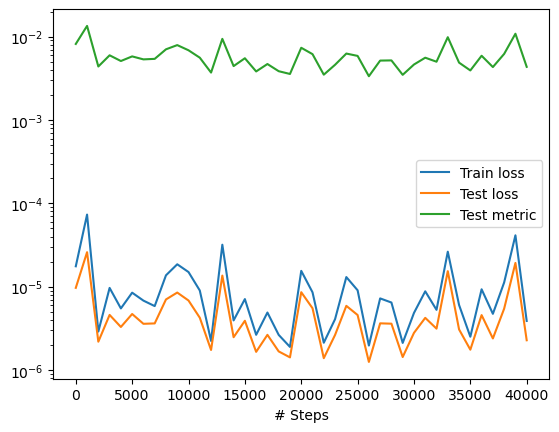

17.791466186110288 1.1092418386640055
300
Compiling model...
'compile' took 0.000206 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.01e-06]    [2.28e-06]    [4.35e-03]    
1000      [9.83e-06]    [4.56e-06]    [5.96e-03]    
2000      [8.46e-07]    [9.78e-07]    [3.05e-03]    
3000      [1.54e-06]    [1.02e-06]    [3.06e-03]    
4000      [4.26e-06]    [2.36e-06]    [4.47e-03]    
5000      [1.10e-06]    [1.03e-06]    [3.10e-03]    
6000      [2.25e-06]    [1.63e-06]    [3.65e-03]    
7000      [1.17e-06]    [1.10e-06]    [3.18e-03]    
8000      [9.51e-07]    [9.74e-07]    [3.03e-03]    
9000      [3.20e-05]    [7.67e-06]    [7.77e-03]    
10000     [9.39e-06]    [2.96e-06]    [4.89e-03]    
11000     [5.08e-06]    [1.76e-06]    [3.86e-03]    
12000     [3.93e-06]    [1.66e-06]    [3.73e-03]    
13000     [2.27e-06]    [1.24e-06]    [3.27e-03]    
14000     [1.92e-06]    [1.18e-06]    [3.18e-03]    
15000     [7.06e-06]    [3.60e-06]    [5.20e-

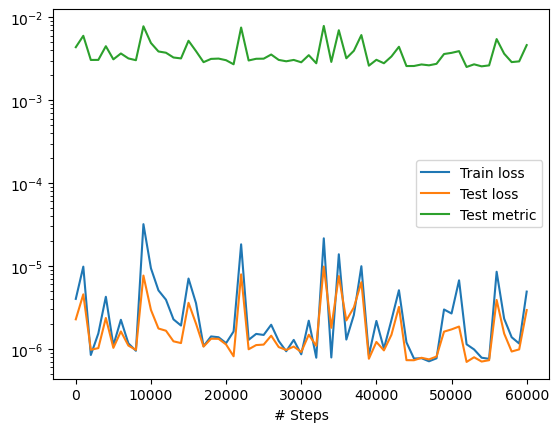

In [9]:

while len(train_vxs) < total_training_vx:
    # generate some vxs to test
    pde_data = dde.data.TimePDE(geomtime, pde, [], num_domain = 20000)
    eval_pts = np.linspace(0, 1, 101)[:, None] # generate 1000 random vxs
    geom = dde.geometry.Interval(0, 1)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    func_space = dde.data.GRF(1.0, length_scale = ls, N= 1000, interp="linear")
    testing_new_data = dde.data.PDEOperatorCartesianProd(pde_data, func_space, eval_pts, check_num, [0])
    # testing_model = dde.Model(testing_new_data, net)
    a, _, c = testing_new_data.train_next_batch()
    l2 = L2_TO_DATA(a[0], train_vxs)
    print(np.mean(l2), np.std(l2))
    topk_index = np.argpartition(l2, -select_num)[-select_num:] # select the top 20 vxs
    topk_vxs = a[0][topk_index]
    uxts = parallel_solver(diffusion_reaction_solver, topk_vxs, num_workers = solver_worker)
    uxts = np.asarray([u for grid, u in uxts]).reshape(-1, 101 * 101)

    # then add the new data to the training set, and train the model
    train_vxs = np.concatenate([train_vxs, topk_vxs], axis = 0)
    train_uxts = np.concatenate([train_uxts, uxts], axis = 0)
    
    print(len(train_vxs))
    data = PDETripleCartesianProd(X_train=(train_vxs, train_grid), y_train=train_uxts, X_test=(test_vxs, test_grid), y_test=test_uxts, boundary = [])
    
    model = dde.Model(data, net)
    lr = lr_middle if len(train_vxs) != total_training_vx else lr_end
    decay = decay_middle if len(train_vxs) != total_training_vx else decay_end
    batchsize = batch_middle(len(train_vxs)) if len(train_vxs) != total_training_vx else batch_end(len(train_vxs))
    iterations = iter_middle if len(train_vxs) != total_training_vx else iter_end
    model.compile("adam", 
                  lr = lr, 
                  metrics = ["mean l2 relative error"],
                  decay = decay,)
    
    losshistory, train_state = model.train(iterations=iterations, batch_size = batchsize)
    
    pd_frame = losshistory.to_pandas()
    pd_frame = pd.concat([pd.read_csv(f"results/loss_history_{date}_l22d.csv"), pd_frame], axis = 0, ignore_index=True)
    pd_frame.to_csv(f"results/loss_history_{date}_l22d.csv", index=False)
    dde.utils.plot_loss_history(losshistory)
    plt.show()
    
torch.save(model.state_dict(), f"results/model_{date}_l2.pth")